In [ ]:
!pip install git+https://github.com/huggingface/transformers.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-g1v8v93i
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-g1v8v93i
  Resolved https://github.com/huggingface/transformers.git to commit 4f05bbf16583a92effb238b4a45b8001083b882c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.0 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.30.0.dev0-py3-none-any.whl size=7066121 sha256=78fdf1b8ebc0ca5036658fa20afda1cd52bab2038155fec547613d5c25877a6c
  Stored in directory: /tmp/pip-ephem-wheel-cache-x0x_g2j5/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512

In [ ]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import DistilBertModel
from transformers import TFDistilBertModel


In [ ]:
#import torch
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
from collections import Counter
import json
import gc
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix
import random


In [ ]:
import nltk
from nltk import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

from string import punctuation, digits
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import itertools
import warnings
warnings.filterwarnings('ignore')

In [ ]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
df = pd.read_csv('/content/Twitter_Part_2.csv')
df.sample(5)

,Unnamed: 0,Line,created_at,user_id,text,merged_labels
2160,2161,4419,Sun Dec 18 08:33:20 +0000 2022,"1,58E+18","@axel_dny Pleureee, juste psk c’est une renoi",none
2089,2090,3963,Sun Dec 18 08:46:38 +0000 2022,"1,56E+18",@Cyrilhanouna @h2oprodoff @C8TV Merci mes chér...,none
591,591,3659,Sun Dec 18 08:54:20 +0000 2022,"1,49E+18",RT @E2Villiers: Devenez migrant l’Etat 🙌vous o...,none
865,865,4650,Sun Dec 18 08:25:25 +0000 2022,"8,22E+17","@Goaldorak2 Non pas sympa ,""cas isolés entends...",none
676,676,4148,Sun Dec 18 08:41:20 +0000 2022,3295818042,@F3Occitanie Voilà ce qui vous attend si un jo...,none


In [ ]:
df.shape

(2307, 6)

In [ ]:
df.merged_labels.unique()

array(['none', 'bullying', 'racism', 'hate speech', 'homophobia',
       'sexism'], dtype=object)

In [ ]:
df.merged_labels.value_counts()

none           1671
hate speech     238
bullying        223
racism          144
sexism           25
homophobia        6
Name: merged_labels, dtype: int64

So there are a total of 6 unique categories represented as strings. We need to encode them by assigning each with a unique number. The following code does that:

In [ ]:
df['encoded_labels'] = df['merged_labels'].astype('category').cat.codes

In [ ]:
df.head()

,Unnamed: 0,Line,created_at,user_id,text,merged_labels,encoded_labels
0,0,3631,Sun Dec 18 08:54:57 +0000 2022,3778501,RT @MSolidarites: 🔥 C'est aujourd'hui 🔥\n \n R...,none,3
1,1,5234,Sun Dec 18 08:04:43 +0000 2022,12700192,@ptiloup44 @CarrPatrick2 Pourquoi MENTEZ-VOUS ...,bullying,0
2,2,5297,Sun Dec 18 08:02:33 +0000 2022,15657767,RT @RAbsolument: Espagne : Un migrant Marocain...,none,3
3,3,4477,Sun Dec 18 08:31:26 +0000 2022,15856141,@ajplusfrancais Comment un migrant arrivant d'...,racism,4
4,4,4761,Sun Dec 18 08:21:48 +0000 2022,17654549,@Charononia Gros cadeau ça !,none,3


## Cleaning the Data

In [ ]:
def clean_text(data):
    """
    input: data: a dataframe containing texts to be cleaned
    return: the same dataframe with an added column of clean text
    """
    clean_data = data.copy()
    clean_data = clean_data[['text', 'encoded_labels']]
    stop_words = stopwords.words('french')
    clean_text = []
    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer()

    for idx in range(len(data)):
        text = clean_data['text'][idx]
        label = clean_data['encoded_labels'][idx]
        text_lowercase = text.lower()
        text_no_stopwords = " ".join([word for word in text_lowercase.split() if word not in (stop_words)])
        text_tokenized = tokenizer.tokenize(text_no_stopwords)
        text_lemmatized = [lemmatizer.lemmatize(token) for token in text_tokenized]
        clean_text = ' '.join(text_lemmatized)
        clean_data['text'][idx] = clean_text
    return clean_data

In [ ]:
clean_data = clean_text(df)

## EDA

In [ ]:
# Counting frequently used words. 
word_list = [word for line in clean_data['text']  for word in line.split()]
sns.set(style="darkgrid")
counts = Counter(word_list).most_common(15)
count_words_df = pd.DataFrame(counts)
count_words_df.columns = ['word', 'frequency']
count_words_df.head(10)

,word,frequency
0,t,1210
1,rt,1118
2,gros,981
3,http,883
4,co,878
5,l,640
6,est,512
7,c,470
8,a,421
9,e,357


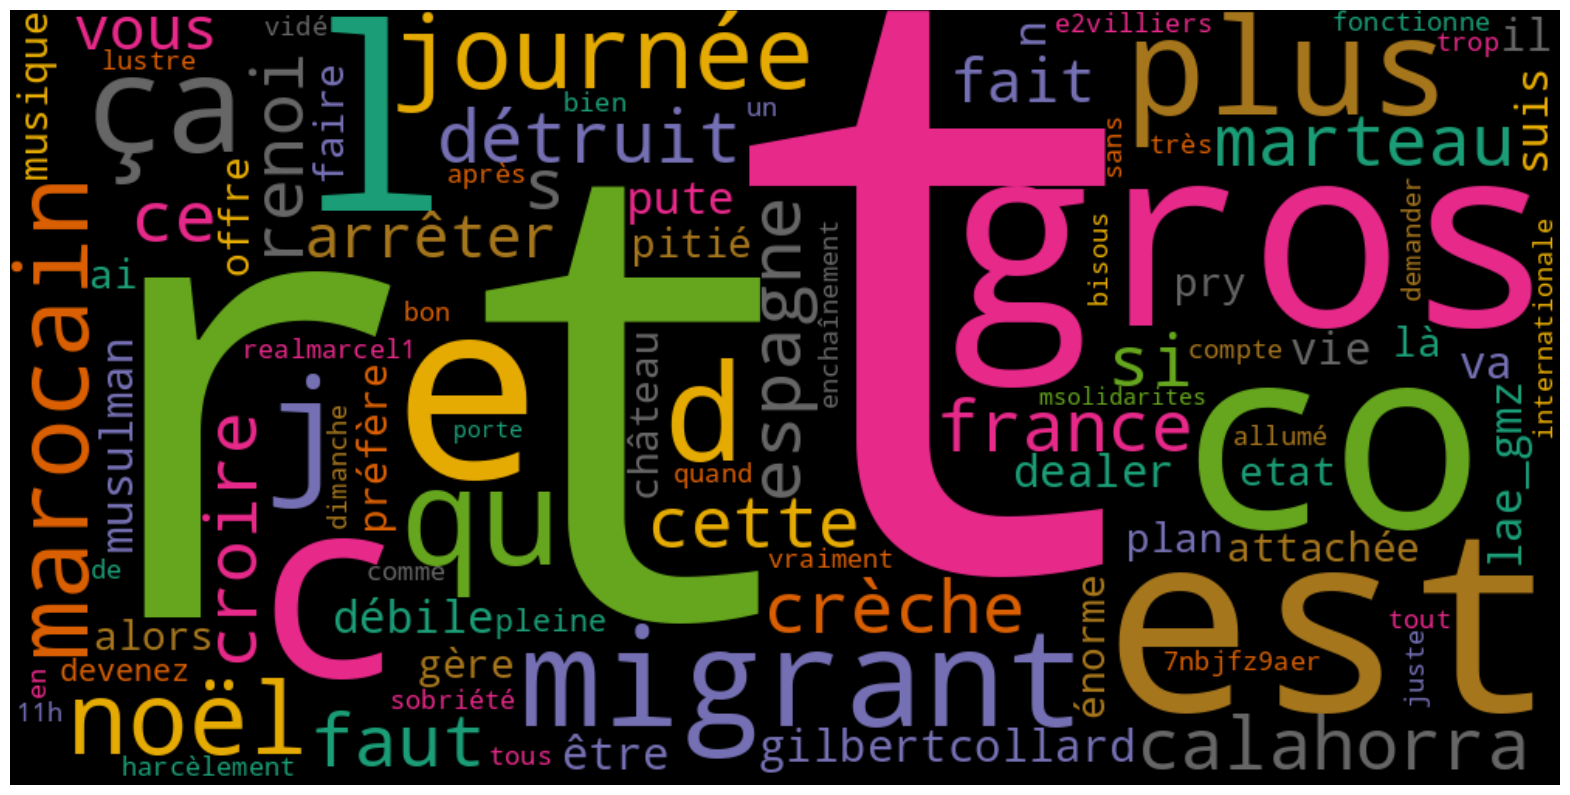

In [ ]:
count_all = Counter(word_list).most_common(100)
all_words_df = pd.DataFrame(count_all)
all_words_df.columns = ['word', 'frequency']

# Creating word_cloud with text as argument in .generate() method
text = " ".join(all_words_df.word)
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, width=1000, height=500, 
                       colormap='Dark2', max_font_size=1350, 
                       background_color = 'black').generate(text)
# Display the generated Word Cloud
plt.rcParams['figure.figsize'] = [20, 15]
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Define Features and Labels

In [ ]:
data_texts = df["text"].to_list() # Features (not-tokenized yet)
data_labels = df["encoded_labels"].to_list() # Lables

In [ ]:
# Split Train and Validation data
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels,
                                                                    test_size=0.2, random_state=0)

In [ ]:
# Keep some data for inference (testing)
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, 
                                                                      test_size=0.01, random_state=0)

## Tokenizing with DistilBert Tokenizer
Fine-tuning in the HuggingFace's **transformers** library involves using a pre-trained model and a tokenizer that is compatible with that model's architecture and input requirements. Each pre-trained model in **transformers** can be accessed using the right model class and be used with the associated tokenizer class. Since we want to use **DistilBert** for a classification task, we will use the **DistilBertTokenizer**'s tokenizer class to tokenize our texts and then use **TFDistilBertForSequenceClassification** model class in a later section to fine-tune the pre-trained model using the output from the tokenizer.

The DistilBertTokenizer generates input_ids and attention_mask as outputs. This is what is required by a DistilBert model as its inputs.

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)

In [ ]:
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

So, in the above code, we defined the tokenizer object using the from_pretrained() method which downloads and caches the tokenizer files associated with the DistilBert model. When we pass text through this tokenizer the generated output will be in the format expected by the DistilBert architecture, as stated above. We use padding and truncation to make sure all the vectors are the same size.

Now that we have our texts in an encoded form, there is only one step left before we can begin the fine-tuning process.

## Creating a Dataset Object for Tenserflow
Before we can move on to the fine-tuning phase, we need to convert our input encodings and labels into a TensorFlow Dataset object. We do this by passing them to the **from_tensor_slices** constructor method.

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

## Fine-tuning Option 1: Using native Tensorflow
We use the from_pretrained() method to initialize a pre-trained model. This will load in the weights and initialize the model with the preset configurations.

### Building  the model and compiling it

In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=6)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_transform', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_19', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5) 
model.compile(optimizer=optimizer, metrics=['accuracy']) #loss=model.compute_loss

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


The DistilBert model and other models available in the transformers library are standard tf.keras.Model classes (and torch.nn.Module in the case of Pytorch), and so we may use them just as we would use a model that we may have defined ourselves using the native TensorFlow and Keras API. Also, notice the num_labels=6 parameter, this is because we have a total of 5 classes.

It is also possible for us to customize the model by changing its configuration. The data is prepared and the model is defined. Let's begin training!

In [ ]:
model.fit(train_dataset.shuffle(1000).batch(16), epochs=6, batch_size=16,
          validation_data=val_dataset.shuffle(1000).batch(16))

Epoch 1/6
116/116 [==============================] - 1017s 8s/step - loss: 0.9185 - accuracy: 0.7333 - val_loss: 0.8180 - val_accuracy: 0.7403
Epoch 2/6
116/116 [==============================] - 935s 8s/step - loss: 0.7040 - accuracy: 0.7783 - val_loss: 0.6949 - val_accuracy: 0.7619
Epoch 3/6
116/116 [==============================] - 912s 8s/step - loss: 0.5696 - accuracy: 0.8060 - val_loss: 0.6306 - val_accuracy: 0.7987
Epoch 4/6
116/116 [==============================] - 920s 8s/step - loss: 0.4377 - accuracy: 0.8520 - val_loss: 0.6845 - val_accuracy: 0.7294
Epoch 5/6
116/116 [==============================] - 880s 8s/step - loss: 0.3455 - accuracy: 0.8916 - val_loss: 0.6897 - val_accuracy: 0.7835
Epoch 6/6
116/116 [==============================] - 912s 8s/step - loss: 0.2967 - accuracy: 0.9084 - val_loss: 0.7270 - val_accuracy: 0.7835


In [ ]:
pd.DataFrame(model.history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.918537,0.733333,0.817960,0.740260
1,0.703954,0.778320,0.694854,0.761905
2,0.569600,0.805962,0.630631,0.798701
3,0.437670,0.852033,0.684500,0.729437
4,0.345487,0.891599,0.689699,0.783550
5,0.296667,0.908401,0.726989,0.783550


<Axes: >

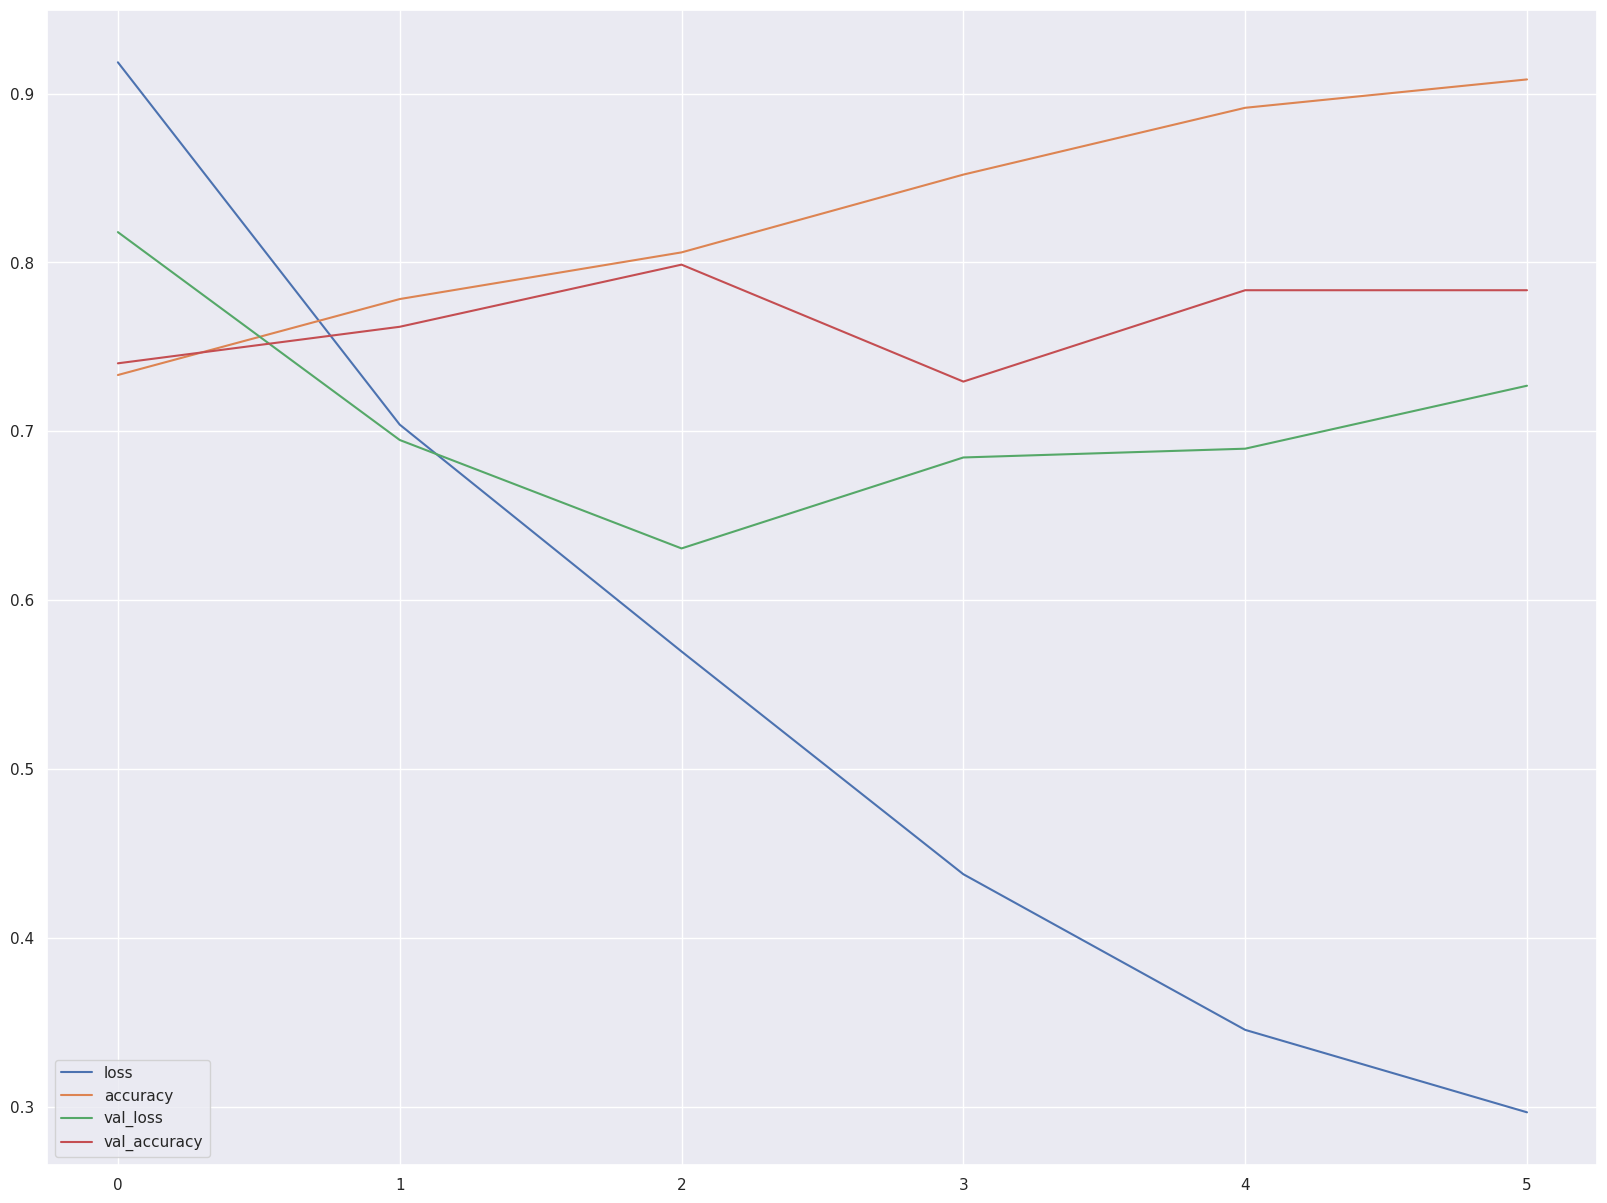

In [ ]:
pd.DataFrame(model.history.history).plot()

In [ ]:
save_directory = "/content/drive/MyDrive/NLP_Project/saved_models" # change this to your preferred location

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('/content/drive/MyDrive/NLP_Project/saved_models/tokenizer_config.json',
 '/content/drive/MyDrive/NLP_Project/saved_models/special_tokens_map.json',
 '/content/drive/MyDrive/NLP_Project/saved_models/vocab.txt',
 '/content/drive/MyDrive/NLP_Project/saved_models/added_tokens.json')

The from_pretrained() method accepts either a model name or a directory to load a model or a tokenizer. Initially, we used the model name (distilbert-base-uncased) to load in our desired model. This time, we will specify the directory to load the saved model.

In [ ]:
loaded_tokenizer = DistilBertTokenizer.from_pretrained(save_directory)
loaded_model = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

Some layers from the model checkpoint at /content/drive/MyDrive/NLP_Project/saved_models were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/NLP_Project/saved_models and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Note:

When you use the from_pretrained() method to initialize a tokenizer or model, the library will download and cache files like the model weights file, tokenizer vocab file, and config files and save them locally. The from_pretrained() method allows you to specify the name of the model that it recognizes or a directory name where it can find the necessary files. You may have to choose one over the other, depending on your application. So for example, in a production environment, you may want to pre-download a model and have it always available in your filesystem.

## Making Predictions with new data
Let's now actually use our fine-tuned model on a sample text from test_text that we created earlier, and see if it can classify the text correctly.

In [ ]:
#function that changes the encoded_label back to category
def predict_sentiment(num):
	if num==0:
		return 'bullying'
	elif num==1:
		return 'hate speech'
	elif num==2:
		return 'homophobia'
	elif num==3:
		return 'none'
	elif num==4:
		return 'racism'
	else:
		return 'sexism'

In [ ]:
test_text = test_texts[16]
test_text

'RT @lae_gmz: « j’suis attachée mais t’es un Renoi, t’es pas musulman, tu pries pas tu préfère dealer » mais pitié qui gère la musique de We…'

In [ ]:
test_label = test_labels[16]
predict_sentiment(test_label) 

'racism'

In [ ]:
predict_input = loaded_tokenizer.encode(test_text,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")

output = loaded_model(predict_input)[0]

prediction_value = tf.argmax(output, axis=1).numpy()[0]
predict_sentiment(prediction_value)

'racism'

In [ ]:
from transformers import DistilBertForSequenceClassification

loaded_tokenizer_pt = DistilBertTokenizer.from_pretrained(save_directory)
loaded_model_pt = DistilBertForSequenceClassification.from_pretrained(save_directory, from_tf=True)

All TF 2.0 model weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.


In [ ]:
import torch
predict_input_pt = loaded_tokenizer_pt.encode(test_text,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="pt")

output_pt = loaded_model_pt(predict_input_pt)[0]

predictions_value_pt = torch.argmax(output_pt[0], dim=-1).item()
predict_sentiment(predictions_value_pt)

'racism'